In [4]:
import spacy
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

# Cargar modelo en español de spaCy
nlp = spacy.load("es_core_news_sm")

# Lista de palabras clave
keywords = ['lluvia', 'inundación', 'accidente', 'apagón', 'deslave', 'desborde', 'incendio', 'fuga', 'colapso']

# Función para eliminar los símbolos, emoticones y links
def clean_text(text):
    text = re.sub(r'http\S+|www.\S+', '', text)
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  
        u"\U0001F300-\U0001F5FF"  
        u"\U0001F680-\U0001F6FF"  
        u"\U0001F700-\U0001F77F"  
        u"\U0001F780-\U0001F7FF"  
        u"\U0001F800-\U0001F8FF"  
        u"\U0001F900-\U0001F9FF"  
        u"\U0001FA00-\U0001FA6F"  
        u"\U0001FA70-\U0001FAFF"  
        u"\U00002700-\U000027BF"  
        u"\U0001F1E0-\U0001F1FF"  
        "]+", flags=re.UNICODE
    )
    text = emoji_pattern.sub(r'', text)
    text = re.sub(r'[^a-zA-ZáéíóúÁÉÍÓÚñÑüÜ\s]', '', text)
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Función para verificar si el tweet contiene una palabra clave o sus variantes
def contains_keyword(text, keywords, nlp):
    doc = nlp(text)
    lemmas = {token.lemma_ for token in doc}
    return any(keyword in lemmas for keyword in keywords)

# Cargar la base de datos
tweets_file = "tweets_Jun20.csv"
df_tweets = pd.read_csv(tweets_file)

# Eliminar tweets que no tienen texto
df_tweets_clean = df_tweets.dropna(subset=['Texto'])

# Aplicar la función de limpieza a la columna de texto
df_tweets_clean['Texto'] = df_tweets_clean['Texto'].apply(clean_text)

# Filtrar los tweets que contienen una palabra clave o sus variantes
df_tweets_filtered = df_tweets_clean[df_tweets_clean['Texto'].apply(lambda x: contains_keyword(x, keywords, nlp))]

# Guardar el resultado filtrado
df_tweets_filtered.to_csv('tweets_filtered.csv', index=False)


/Users/Daniel/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/var/folders/8b/d34q145x44x2xf_06_gchyfw0000gq/T/ipykernel_67421/4240776846.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_clean['Texto'] = df_tweets_clean['Texto'].apply(clean_text)


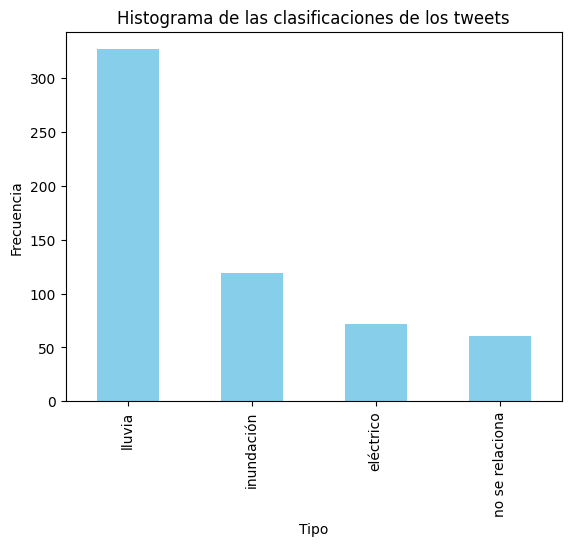

In [11]:
tweets_clean_classified = "tweets_better_classified.csv"
df_tweets_clean_fil = pd.read_csv(tweets_clean_classified)

tipo_counts = df_tweets_clean_fil['Tipo'].value_counts()

# Creación del histograma
tipo_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Tipo')
plt.ylabel('Frecuencia')
plt.title('Histograma de las clasificaciones de los tweets')
plt.show()